# Plot the Results

In [1575]:
import os
import seaborn as sns
sns.set_theme(style="darkgrid", palette='pastel')
current_palette = sns.color_palette()
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

In [1576]:
def fine_upperbound(points_x, points_y):
    points = np.array(list(zip(points_x, points_y)))
    hull = ConvexHull(points)
    upper_hull_points = []
    for simplex in hull.simplices:
        for vertex in simplex:
            upper_hull_points.append(points[vertex])
    upper_hull_points = sorted(set(map(tuple, upper_hull_points)))
    return list(zip(*upper_hull_points))

In [1577]:
def getlocalmax(x,y,bins = 20):
    x = np.array(x)
    logx = np.log(x)
    y = np.array(y)

    sorted_indices = np.argsort(logx)
    x = x[sorted_indices]
    logx = logx[sorted_indices]
    y = y[sorted_indices]

    x_min, x_max = logx[0], logx[-1]
    bin_width = (x_max - x_min) / bins

    newx = []
    newy = []

    for i in range(bins):
        start = x_min + i * bin_width
        end = start + bin_width
        
        indices = (logx >= start) & (logx < end)
        if np.any(indices):
            max_index = np.argmax(y[indices])
            actual_indices = np.where(indices)[0]
            newx.append(x[actual_indices[max_index]])
            newy.append(y[actual_indices[max_index]])
    return newx, newy

def getlocalmin(x,y,bins = 20):
    x = np.array(x)
    logx = np.log(x)
    y = np.array(y)

    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    logx = logx[sorted_indices]
    y = y[sorted_indices]

    x_min, x_max = logx[0], logx[-1]
    bin_width = (x_max - x_min) / bins

    newx = []
    newy = []

    for i in range(bins):
        start = x_min + i * bin_width
        end = start + bin_width
        
        indices = (logx >= start) & (logx < end)
        if np.any(indices):
            min_index = np.argmin(y[indices])
            actual_indices = np.where(indices)[0]
            newx.append(x[actual_indices[min_index]])
            newy.append(y[actual_indices[min_index]])
    return newx, newy

In [1578]:
def crop(x,y, start, end):
    x = np.array(x)
    y = np.array(y)
    indices = (x >= start) & (x <= end)
    return x[indices], y[indices]

In [1579]:
def getresults(lines):
    results = {"KAN": {}, "MLP": {}, "KAF": {}, "GPKAN": {},"FAN":{}}
    for line_num, line in enumerate(lines, 1):
        try:
            line = line.strip(" \n\t")
            items = line.split(",")
            if ",KAN," in line or ",KAN_Text," in line:
                # Filter out elements with value "adam"
                items = [item for item in items if item.lower() != "adam"]

                _, dataset, model, layer_widths, batch_norm, activation_name, batch_size, epochs, learning_rate, seed, kan_bspline_grid, kan_bspline_order, kan_shortcut_name, kan_range, train_acc, test_acc, num_parameter, flops, total_training_time, training_time_per_epoch = items
                if dataset not in results["KAN"]:
                    results["KAN"][dataset] = {}
                key = (layer_widths, kan_bspline_grid, kan_bspline_order, kan_shortcut_name, kan_range)
                if key in results["KAN"][dataset]:
                    results["KAN"][dataset][key].append((float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch)))
                else:
                    results["KAN"][dataset][key] = [(float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch))]

            elif ",MLP," in line or ",MLP_Text," in line:
                _, dataset, model, layer_widths, batch_norm, activation_name, batch_size, epochs, learning_rate, seed, optimizer, train_acc, test_acc, num_parameter, flops, total_training_time, training_time_per_epoch = items
                if dataset not in results["MLP"]:
                    results["MLP"][dataset] = {}
                key = (layer_widths)
                if key in results["MLP"][dataset]:
                    results["MLP"][dataset][key].append((float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch)))
                else:
                    results["MLP"][dataset][key] = [(float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch))]

            elif ",KAF," in line or ",KAF_Text" in line:
                _, dataset, model, layer_widths, batch_norm, activation_name, batch_size, epochs, learning_rate, seed, optimizer, num_experts, expert_factor, expert_params, train_acc, test_acc, num_parameter, flops, total_training_time, training_time_per_epoch = items
                if dataset not in results["KAF"]:
                    results["KAF"][dataset] = {}
                key = (layer_widths, num_experts, expert_factor, expert_params)
                if key in results["KAF"][dataset]:
                    results["KAF"][dataset][key].append((float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch)))
                else:
                    results["KAF"][dataset][key] = [(float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch))]

            elif ",GPKAN," in line or ",GPKAN_Text," in line:
                _, dataset, model, layer_widths, batch_norm, activation_name, batch_size, epochs, learning_rate, seed, optimizer, gp_kernel, gp_lengthscale, gp_variance, train_acc, test_acc, num_parameter, flops, total_training_time, training_time_per_epoch = items
                if dataset not in results["GPKAN"]:
                    results["GPKAN"][dataset] = {}
                key = (layer_widths, gp_kernel, gp_lengthscale, gp_variance)
                if key in results["GPKAN"][dataset]:
                    results["GPKAN"][dataset][key].append((float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch)))
                else:
                    results["GPKAN"][dataset][key] = [(float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch))]

            elif ",FAN," in line or ",FAN_Text," in line:
                _, dataset, model, layer_widths, batch_norm, activation_name, batch_size, epochs, learning_rate, seed, optimizer, gp_kernel, gp_lengthscale, gp_variance, train_acc, test_acc, num_parameter, flops, total_training_time, training_time_per_epoch = items
                if dataset not in results["FAN"]:
                    results["FAN"][dataset] = {}
                key = (layer_widths, gp_kernel, gp_lengthscale, gp_variance)
                if key in results["FAN"][dataset]:
                    results["FAN"][dataset][key].append((float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch)))
                else:
                    results["FAN"][dataset][key] = [(float(train_acc), float(test_acc), float(num_parameter), float(flops), float(total_training_time), float(training_time_per_epoch))]
            else:
                print(f"Unknown model type at line {line_num}: {line}")
                continue

        except Exception as e:
            print(f"Error processing line {line_num}: {line}")
            print(f"Error message: {str(e)}")
            continue

    if not results["KAF"]:
        print("No KAF data")
    else:
        print("After loading KAF data:")

    if not results["GPKAN"]:
        print("No GPKAN data")
    else:
        print("After loading GPKAN data:")

    return results


In [ ]:
f = open("../results/results.csv", "r")
lines = f.readlines()
results = getresults(lines)

# 统计KAN数据行数
kan_total_rows = 0
for dataset in results["KAN"]:
    for key in results["KAN"][dataset]:
        kan_total_rows += len(results["KAN"][dataset][key])
print(f"Total number of KAN data rows: {kan_total_rows}")

In [1581]:
vision_datasets = ["MNIST", 'EMNIST-Balanced', 'EMNIST-Letters',"FMNIST", "KMNIST",'Cifar10', "Cifar100","SVHN"]

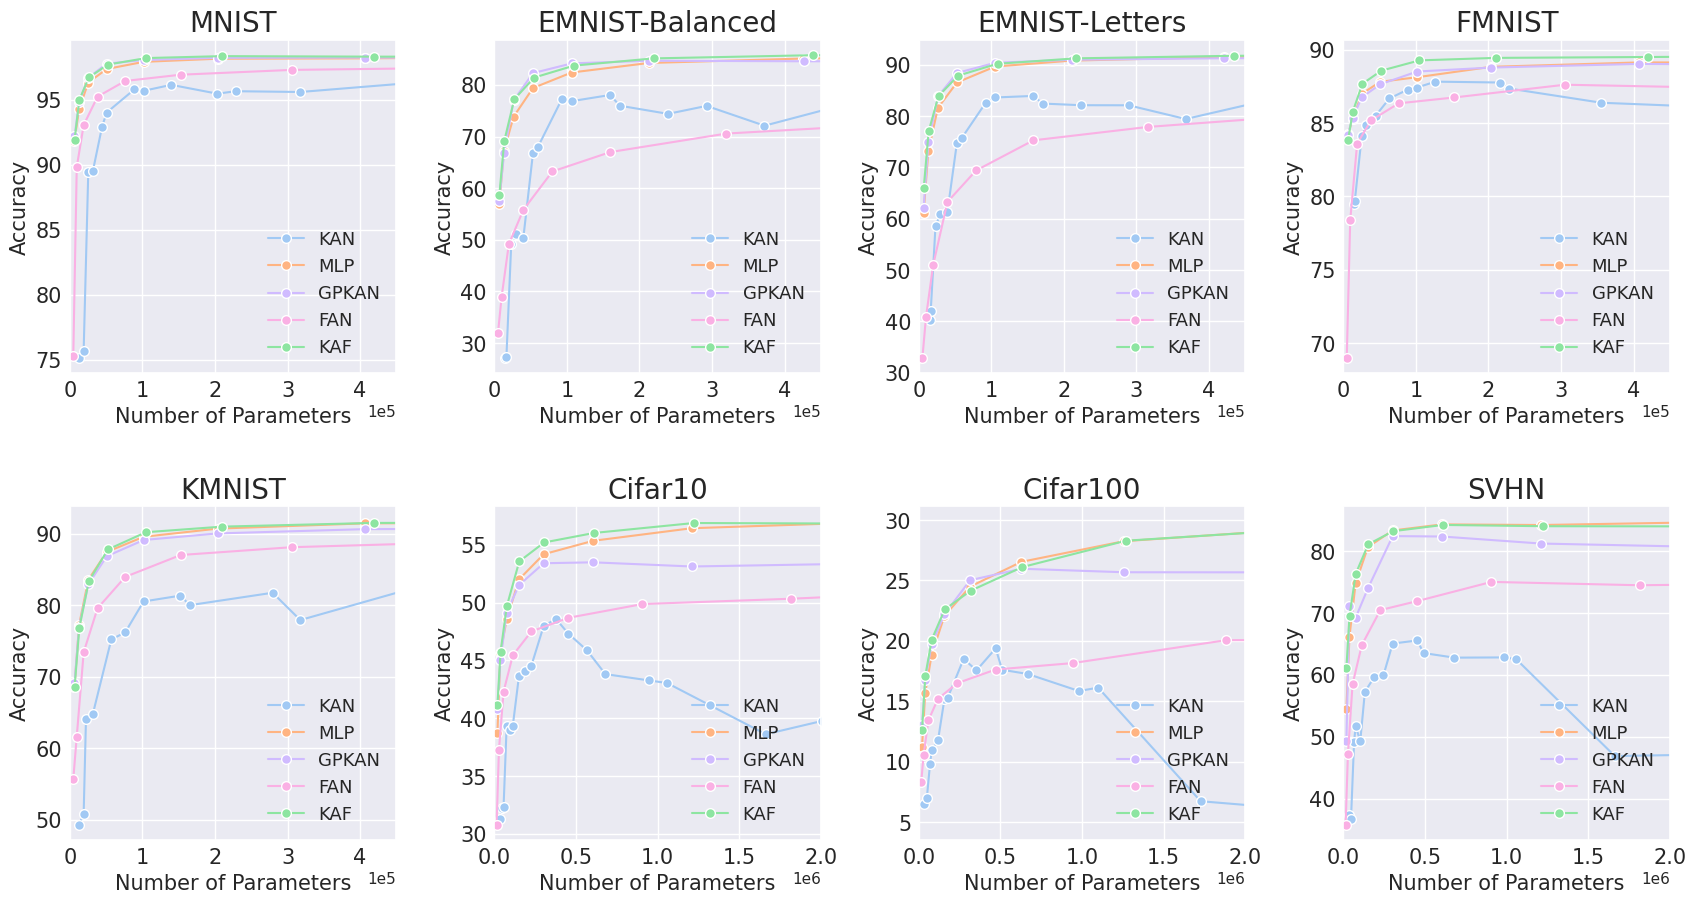

In [1582]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)

for i, dataset in enumerate(vision_datasets):
    ax = axs[i//4, i%4]
    
    # KAN data
    kan_x, kan_y = [], []
    for items in results["KAN"][dataset].values():
        for item in items:
            kan_x.append(item[2])
            kan_y.append(item[1])
    kan_x, kan_y = getlocalmax(kan_x, kan_y, 20)
    
    # MLP data
    mlp_x, mlp_y = [], []
    for items in results["MLP"][dataset].values():
        for item in items:
            mlp_x.append(item[2])
            mlp_y.append(item[1])
    mlp_x, mlp_y = getlocalmax(mlp_x, mlp_y, 20)
    
    # KAF data
    KAF_x, KAF_y = [], []
    if dataset in results["KAF"]:  # Check if dataset has KAF results
        for items in results["KAF"][dataset].values():
            for item in items:
                KAF_x.append(item[2])
                KAF_y.append(item[1])
        KAF_x, KAF_y = getlocalmax(KAF_x, KAF_y, 200)
    
    # GPKAN data
    gpkan_x, gpkan_y = [], []
    if dataset in results["GPKAN"]:  # Check if dataset has GPKAN results
        for items in results["GPKAN"][dataset].values():
            for item in items:
                gpkan_x.append(item[2])
                gpkan_y.append(item[1])
        gpkan_x, gpkan_y = getlocalmax(gpkan_x, gpkan_y, 200)
    
    # FAN data
    fan_x, fan_y = [], []
    if dataset in results["FAN"]:  # Check if dataset has FAN results
        for items in results["FAN"][dataset].values():
            for item in items:
                fan_x.append(item[2])
                fan_y.append(item[1])
        fan_x, fan_y = getlocalmax(fan_x, fan_y, 200)
    

    # Plot curves
    ax.plot(kan_x, kan_y, color=current_palette[0], label="KAN", marker="o", markersize=7, markeredgecolor="white")
    ax.plot(mlp_x, mlp_y, color=current_palette[1], label="MLP", marker="o", markersize=7, markeredgecolor="white")
    if len(gpkan_x) > 0:  # Plot GPKAN data if available
        ax.plot(gpkan_x, gpkan_y, color=current_palette[4], label="GPKAN", marker="o", markersize=7, markeredgecolor="white")
    if len(fan_x) > 0:  # Plot FAN data if available
        ax.plot(fan_x, fan_y, color=current_palette[6], label="FAN", marker="o", markersize=7, markeredgecolor="white")
    if len(KAF_x) > 0:  # Plot KAF data if available
        ax.plot(KAF_x, KAF_y, color=current_palette[2], label="KAF", marker="o", markersize=7, markeredgecolor="white")
    ax.set_title(dataset, fontsize=20)
    ax.set_xlabel("Number of Parameters", fontsize=15)
    ax.set_ylabel("Accuracy", fontsize=15)
    ax.tick_params('y', length=2, width=0, labelsize=15)
    ax.tick_params('x', length=2, width=0, labelsize=15)
    # Set scientific notation format for x-axis
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    if dataset in ["MNIST", 'EMNIST-Balanced', 'EMNIST-Letters', "FMNIST", "KMNIST"]:
        ax.set_xlim(0, 4.5e5)
    else:
        ax.set_xlim(0, 2e6)

    ax.legend(loc="lower right", fontsize=13, frameon=False)


plt.show()
fig.savefig(f"imgs/vision_num_parameter.pdf", format='pdf', bbox_inches='tight')
